In [ ]:
import pandas as pd
import numpy as np
import torch
from scipy.stats import gamma, norm
from darts.models import RNNModel,RegressionModel , RandomForest, XGBModel
from darts.metrics import rmse, mape,mae, smape
# from darts.utils.preprocessing import Scaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from darts.dataprocessing.transformers.scaler import Scaler
# from darts.ad import ThresholdAD
from darts import TimeSeries

import pywt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose


from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_SHAPE
from pptx.dml.color import RGBColor

import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
from pandas.tseries.offsets import MonthEnd

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



Read and preprocess the input data


In [ ]:

def load_data(csv_path):
    df = pd.read_csv(csv_path, parse_dates=["ds"])
    df.rename(columns={
        "ds": "date",
        "precip": "rainfall",
        "SPI_1": "spi1",
        "SPI_3": "spi3",
        "SPI_6": "spi6",
        "SPI_9": "spi9",
        "SPI_12": "spi12",
        "SPI_24": "spi24",
        "station_id": "station"
    }, inplace=True)
    df.set_index("date", inplace=True)

    return df


def remove_seasonality(series):
    decomposition = seasonal_decompose(series, model='additive', period=12, extrapolate_trend='freq')
    deseasonalized = series - decomposition.seasonal
    return deseasonalized, decomposition.seasonal


def make_features(df, timescale, lags=12):
    # Use SPI timescale and rainfall as covariates
    data = df[[f"spi{timescale}", "rainfall"]].copy()
    data = data.rename(columns={f"spi{timescale}": "spi"})
    data.dropna(inplace=True)



    # remove seasonality
    # data['spi_deseason'] = remove_seasonality(data['spi'])
    data['spi_deseason'], seasonal = remove_seasonality(data['spi'])
    data['seasonal'] = seasonal

    # lag features
    for lag in range(1, lags+1):
        data[f'spi_lag_{lag}'] = data['spi_deseason'].shift(lag)
    data.dropna(inplace=True)
    return data



class TaylorDiagram

In [ ]:

class TaylorDiagram:
    def __init__(self, ref_std, fig=None, rect=111, label='Reference'):
        self.ref_std = ref_std
        self.sample_points = []

        self.fig = fig if fig is not None else plt.figure(figsize=(8, 6))
        self.ax = self.fig.add_subplot(rect, polar=True)

        # Configure polar axes
        self.ax.set_theta_zero_location('E')

        self.ax.set_theta_direction(-1)
        self.ax.set_theta_offset(np.pi / 2)
        self.ax.set_ylim(0, 1.5 * ref_std)
        self.ax.set_thetamin(0)
        self.ax.set_thetamax(90)

        # Set up correlation coefficient grid
        self._setup_axes()

        # Plot reference point
        self.ax.plot([0], [ref_std], 'k*', markersize=12, label=label)

    def _setup_axes(self):
        corrs = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1.0])
        angles = np.arccos(corrs)

        self.ax.set_thetagrids(np.degrees(angles), labels=[f"{c:.2f}" for c in corrs], fontsize=10)
        self.ax.set_rlabel_position(135)
        self.ax.set_ylabel('Standard Deviation', fontsize=12)

        # Add radial grid lines manually
        for angle in angles:
            self.ax.plot([angle, angle], [0, self.ax.get_ylim()[1]], color='lightgray', linestyle='--', linewidth=0.5)

    def add_sample(self, stddev, corrcoef, label, marker='o', color=None):
        theta = np.arccos(corrcoef)
        point, = self.ax.plot(theta, stddev, marker=marker, label=label, color=color, markersize=8)
        self.sample_points.append(point)

    def add_contours(self, levels=6, cmap='coolwarm', linewidths=1.2):
        rs, ts = np.meshgrid(
            np.linspace(0, self.ax.get_ylim()[1], 300),
            np.linspace(0, np.pi / 2, 300)
        )
        rms = np.sqrt(
            self.ref_std**2 + rs**2 - 2 * self.ref_std * rs * np.cos(ts)
        )
        contours = self.ax.contour(
            ts, rs, rms,
            levels=np.linspace(0, self.ax.get_ylim()[1], levels),
            cmap=cmap,
            linewidths=linewidths
        )
        self.fig.colorbar(contours, ax=self.ax, pad=0.1, orientation='vertical', label="RMS Difference")
        return contours

    def show(self, title='Taylor Diagram'):
        self.ax.set_title(title, fontsize=14, pad=20)
        self.ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.tight_layout()
        plt.show()


Define Models and train


In [30]:

class WBBLSTMModel:
    def __init__(self, wavelet='db1', level=1, **lstm_kwargs):
        self.wavelet = wavelet
        self.level = level
        self.lstm_kwargs = lstm_kwargs
        self.lstm_model = RNNModel(model='LSTM', **lstm_kwargs)
        
    def wavelet_decompose(self, series: TimeSeries):
        coeffs = pywt.wavedec(series.values().flatten(), self.wavelet, level=self.level)
        return coeffs
    
    def wavelet_reconstruct(self, coeffs):
        return pywt.waverec(coeffs, self.wavelet)
    
    def fit(self, series: TimeSeries):
        # Decompose
        coeffs = self.wavelet_decompose(series)
        approx = coeffs[0]  # Use approximation coeffs as input to LSTM
        approx_series = TimeSeries.from_values(approx.reshape(-1, 1))
        
        # Fit the internal LSTM model
        self.lstm_model.fit(approx_series)

    def predict(self, n,series):
        # 1) Decompose historical series into coeffs
        hist_coeffs = self.wavelet_decompose(series)
        hist_approx, *hist_details = hist_coeffs

        # 2) Forecast only the approximation coeffs (with correct time index)
        approx_ts = self.lstm_model.predict(n, series=series)
        approx_pred = approx_ts.values().flatten()

        # 3) Build a new approximation array: [historic approx | predicted approx]
        full_approx = np.concatenate([hist_approx, approx_pred])


        dummy_signal = np.zeros_like(approx_pred)

        # 2. Decompose dummy to get the correct coeff shapes
        dummy_coeffs = pywt.wavedec(dummy_signal, self.wavelet, level=self.level)

        full_coeffs   = [full_approx] + [np.zeros_like(c) for c in dummy_coeffs[1:]]
        print("Full approx length:", len(full_approx))
        print("Expected shapes:")
        for i, c in enumerate(dummy_coeffs):
            print(f"  Coeff {i}: shape = {c.shape}")

        print("\nYour full_coeffs shapes:")
        for i, c in enumerate(full_coeffs):
                print(f"  Coeff {i}: shape = {c.shape}")

        

        # 3. Replace only the *approximation level* with your forecast (but RESHAPED to the correct length)
        approx_pred_downsampled = pywt.wavedec(approx_pred, self.wavelet, level=self.level)[0]

        # 4. Now use it with the correct detail coeff shapes
        coeffs = [approx_pred_downsampled] + [np.zeros_like(c) for c in dummy_coeffs[1:]]

        # 5. Reconstruct
        full_series = self.wavelet_reconstruct(coeffs)

        # 5) zero out all detail levels (you could also keep hist_details if you want)

        # # 6) reconstruct the full signal
        # full_series   = self.wavelet_reconstruct(full_coeffs)

        # 7) extract just the last n points (the forecast window)
        forecast_vals = full_series[-n:]

        # 8) wrap back into TimeSeries with the right ds index
        return TimeSeries.from_times_and_values(
            approx_ts.time_index,
            forecast_vals.reshape(-1, 1),
            columns=approx_ts.components
        )
    def save(self, path):
        # os.makedirs(path, exist_ok=True)

        # Save LSTM model
        self.lstm_model.save(path)

        # Save wavelet settings and kwargs
        meta = {
        'wavelet': self.wavelet,
            'level': self.level,
            'lstm_kwargs': self.lstm_kwargs
        }

        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load(cls, path):
        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "r") as f:
            meta = json.load(f)


        wavelet = meta['wavelet']
        level = meta['level']
        lstm_kwargs = meta['lstm_kwargs']
        instance = cls(wavelet=wavelet, level=level, **lstm_kwargs)

        # instance = cls(**meta)
        instance.lstm_model = RNNModel.load(path)
        return instance



window_size = 12
num_epochs=100
horizon = 1 


model_constructors = {
       'ExtraTF': lambda: XGBModel(
         lags=window_size,
        lags_future_covariates=[0],
         output_chunk_length=horizon,
         random_state=SEED,
         objective='reg:squarederror'
    ),
    'RandomRF': lambda: RandomForest(
         lags=window_size,
         lags_future_covariates=[0],
         output_chunk_length=horizon,
         n_estimators=200,
         criterion="absolute_error",
         random_state=SEED
    ),
    'SVR': lambda: RegressionModel(
         model=SVR(kernel='rbf'),
         lags_future_covariates=[0],
         lags=window_size,
         output_chunk_length=horizon
    ),
    'LSTM': lambda: RNNModel(
         model='LSTM',
         input_chunk_length=window_size,
         output_chunk_length=horizon,
         hidden_dim=25,
         n_rnn_layers=2,
         dropout=0.1,
         batch_size=16,
         n_epochs=num_epochs,
         optimizer_kwargs={'lr':1e-3},
         random_state=SEED
    ),
    'WBBLSTM'   : lambda: WBBLSTMModel(
        wavelet='db1',
        level=1,
        input_chunk_length=window_size,
        output_chunk_length=horizon,
        hidden_dim=25,
        n_rnn_layers=2,
        dropout=0.1,
        batch_size=16,
        n_epochs=num_epochs,
        optimizer_kwargs={'lr':1e-3},
        random_state=SEED
    )
}



main loop



=== Station 40700 | 1 ===
Model ExtraTF already trained. Skipping.
!!!@@@-----Loading ExtraTF model from results\40700/1\ExtraTF…
Model RandomRF already trained. Skipping.
!!!@@@-----Loading RandomRF model from results\40700/1\RandomRF…
Model SVR already trained. Skipping.
!!!@@@-----Loading SVR model from results\40700/1\SVR…
Model LSTM already trained. Skipping.
!!!@@@-----Loading LSTM model from results\40700/1\LSTM…


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
Model WBBLSTM already trained. Skipping.

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.



!!!@@@-----Loading WBBLSTM model from results\40700/1\WBBLSTM…


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
Full approx length: 241
Expected shapes:
  Coeff 0: shape = (41,)
  Coeff 1: shape = (41,)

Your full_coeffs shapes:
  Coeff 0: shape = (241,)
  Coeff 1: shape = (41,)
negative corr
std_p: 0.73, corr: 0.81, rmse: 0.48, mae_v: 0.37,sm: 86.98 - ExtraTF 
std_p: 0.68, corr: 0.83, rmse: 0.46, mae_v: 0.34,sm: 77.22 - RandomRF 
std_p: 0.67, corr: 0.84, rmse: 0.45, mae_v: 0.32,sm: 69.37 - SVR 
std_p: 0.82, corr: 0.82, rmse: 0.49, mae_v: 0.39,sm: 87.40 - LSTM 
std_p: 0.49, corr: 0.12, rmse: 0.96, mae_v: 0.76,sm: 143.39 - WBBLSTM 


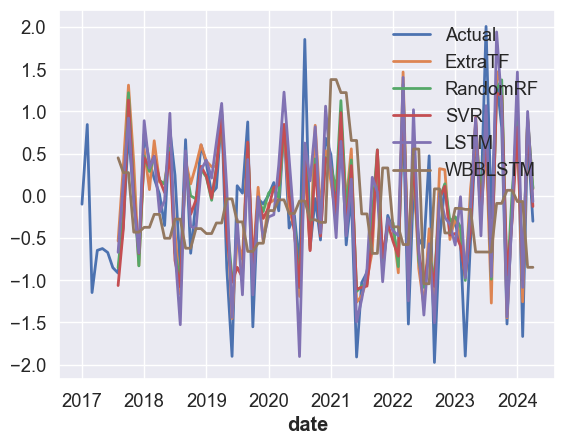

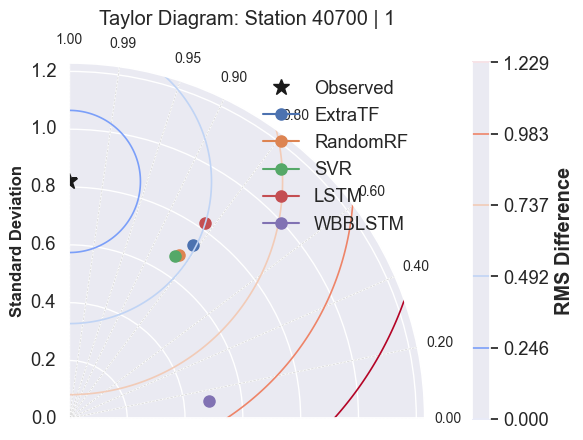

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


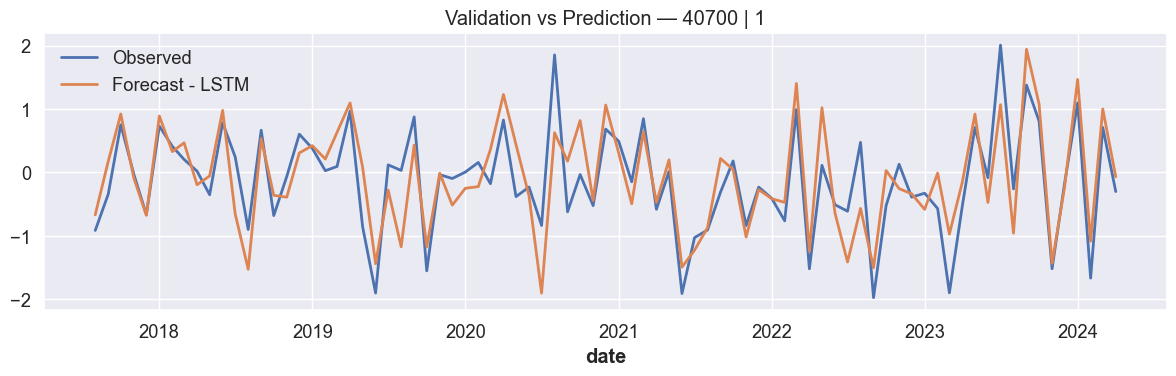

✔️ Done with 40700 | 1


=== Station 40700 | 3 ===
!!!@@@------Training ExtraTF…

ValueError: cannot reshape array of size 0 into shape (0,newaxis,1)

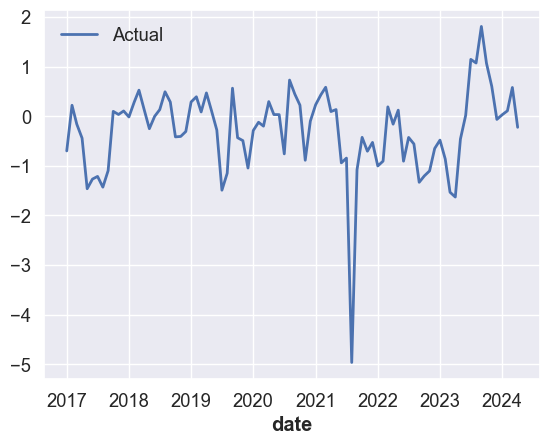

In [ ]:
results = {}  
base_dir = "results"
os.makedirs(base_dir, exist_ok=True)

df = load_data('./finaldata.csv')
stations = df['station'].unique()
summary = []

def model_score(stats):
    std_o, std_p, corr, rmse, mape_val, _ = stats
    std_diff = abs(std_o - std_p)
    return (
        rmse + mape_val + std_diff - corr  # lower is better
    )

# for st in stations:
for st in [40700]:
    df_st = df[df['station'] == st].copy()
    for ts in [1,3,6,9,12,24]:
    # for ts in [3]:
        results[st] = {}
        data = make_features(df_st, ts)
        print(f"\n=== Station {st} | {ts} ===")
        target_series = TimeSeries.from_series(data["spi_deseason"])
        covariates = TimeSeries.from_dataframe(
            data[["rainfall"] + [f"spi_lag_{i}" for i in range(1, 13)]]
        )

        train, val = target_series.split_before(0.8)
        target_series.slice(pd.Timestamp("2017-01-01"),pd.Timestamp("2024-04-01")).plot(label="Actual")
        # cov_train, cov_val = covariates.split_before(0.8)

        

        model_folder = os.path.join(base_dir, f"{st}/{ts}")
        os.makedirs(model_folder, exist_ok=True)


        model_stats = {}
        forecasts = {}
        for name, mk in model_constructors.items():
            # if name != 'LSTM':
            #      continue
            model_path = os.path.join(model_folder, name)
            if os.path.exists(model_path):
                print(f"Model {name} already trained. Skipping.")
                model_class = {
                    'LSTM': RNNModel,
                    'SVR': RegressionModel,
                    'RandomRF': RandomForest,
                    'ExtraTF': XGBModel,
                    'WBBLSTM': WBBLSTMModel
                }[name]
                print(f"!!!@@@-----Loading {name} model from {model_path}…")
                model = model_class.load(model_path)

            else:
                print(f"!!!@@@------Training {name}…", end='')
                model = mk()
                if name == 'WBBLSTM':
                    model.fit(series=train) 
                else:
                    model.fit(series=train, future_covariates=covariates)
                    # model.fit(series=train)

                model.save(model_path)

                print(" saved.")
            if name == 'WBBLSTM':
                forecast = model.predict(len(val), series=train)
            else:
                forecast = model.predict(len(val), series=train, future_covariates=covariates)
                # forecast = model.predict(len(val), series=train)
            forecast.plot(label=name)

            o = val.values().flatten()
            p = forecast.values().flatten()

            corr = pearsonr(o, p)[0]
            if corr < 0:
                print('negative corr')
                p = -p
                corr = -corr


            rm   = np.sqrt(mean_squared_error(o, p))
            mae_v= mean_absolute_error(o, p)
            sm   = np.mean(2 * np.abs(o-p) / (np.abs(o)+np.abs(p))) * 100

            model_stats[name] = (np.std(o), np.std(p), corr, rm, mae_v, sm)
            
            forecasts[name] = forecast

        results[st][f"spi_{ts}"] = model_stats
        for model_name, stats in model_stats.items():
                        std_o, std_p, corr, rmse, mae, smape = stats
                        score = model_score(stats)
                        summary.append({
                            'Station': st,
                            'Timescale': ts,
                            'Model': model_name,
                            'STD_Obs': std_o,
                            'STD_Pred': std_p,
                            'Corr': corr,
                            'RMSE': rmse,
                            'MAE': mae,
                            'SMAPE': smape,
                            'Score': score,
                        })
        # Taylor Diagram
        ref_std = list(model_stats.values())[0][0]
        fig = plt.figure(figsize=(6, 6))
        taylor = TaylorDiagram(ref_std, fig, label='Observed')
        for name, (std_o, std_p, corr, rmse,mae_v,sm) in model_stats.items():
            print(f"std_p: {std_p:.2f}, corr: {corr:.2f}, rmse: {rmse:.2f}, mae_v: {mae_v:.2f},sm: {sm:.2f} - {name} ")
            if np.isnan(std_p) or np.isnan(corr) or std_p == 0:
                print(f"⚠️ Skipping {name} due to invalid metrics.")
                continue
            taylor.add_sample(std_p, corr, label=name)
        taylor.add_contours()
        plt.legend()
        plt.title(f"Taylor Diagram: Station {st} | {ts}")
        plt.tight_layout()
        fig.savefig(os.path.join(model_folder, f"/taylor_{st}_{ts}.png"))
        plt.show()

        # Best model
        best_model = min(model_stats.items(), key=lambda x: model_score(x[1]))[0]
        best = model_constructors[best_model]()
        # if best_model == 'WBBLSTM':
        #     best.fit(series=target_series) 
        # else:
        #     # best.fit(series=target_series, future_covariates=covariates)
        #     best.fit(series=target_series)

        

        # cov_df = covariates.pd_dataframe()  # or however you get a pandas DataFrame
        # cov_df['month'] = cov_df.index.month

        # # Compute monthly means for each column except 'month'
        # monthly_means = cov_df.groupby('month').mean()

        # # 2) Build the future date index from May 2024 to April 2051
        # last_hist = covariates.end_time()         # e.g. Timestamp('2024-04-01 00:00:00')
        # start_future = last_hist + MonthEnd(1)    # gives end of month, but for MS freq it lines up
        # future_idx = pd.date_range(start=start_future,
        #                         end="2051-04-01",
        #                         freq="MS")

        # # 3) Create a DataFrame for future covariates by mapping each future month to its climatology
        # df_future = pd.DataFrame(index=future_idx)

        # # For each covariate column, fill with the corresponding monthly mean
        # for col in monthly_means.columns:
        #     df_future[col] = [monthly_means.loc[m, col] for m in df_future.index.month]

        # # 4) Convert to a Darts TimeSeries
        # full_df = pd.concat([covariates.pd_dataframe(), df_future])
        # future_covariates = TimeSeries.from_dataframe(full_df)
        # future_covariates = TimeSeries.from_dataframe(df_future)
        # Forecast to 2050
        horizon = (pd.Timestamp("2050-12-01") - target_series.end_time()).days // 30
        # future = best.predict(horizon, series=target_series,future_covariates=future_covariates)
        # future = best.predict(horizon, series=target_series)


        # if not isinstance(future.time_index, pd.DatetimeIndex):
        #     future = TimeSeries.from_times_and_values(
        #         pd.date_range(
        #             start=target_series.end_time() + pd.DateOffset(months=1),
        #             periods=len(future),
        #             freq="MS"
        #         ),
        #         future.values(),
        #         columns=target_series.components
        #     )

        # historical = target_series
        # full_series = historical.append(future)

        # plt.figure(figsize=(12, 4))
        # full_series.plot(label="SPI")
        # plt.axvline(x=historical.end_time(), color='r', linestyle='--', label="Forecast Start")
        # plt.title(f"Forecast 2050 {st} | {ts}: {best_model}")

        # plt.xlabel("Time")
        # plt.ylabel("SPI")
        # plt.grid(True)
        # plt.legend()
        # plt.tight_layout()
        # plt.savefig(os.path.join(model_folder, f"{st}/Forecast_{ts}.png"))
        # plt.show()

        # Plot val vs forecast
        _, val = target_series.split_before(0.8)
        time_idx = val.time_index
        pred = forecasts[best_model]
        val_df  = val.to_dataframe()   # gives you a DataFrame with a DatetimeIndex
        pred_df = pred.to_dataframe()
        plt.figure(figsize=(12, 4))
        val.plot(label="Observed")
        pred.plot(label=f"Forecast - {best_model}")
        plt.title(f"Validation vs Prediction — {st} | {ts}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(model_folder, f"/val_vs_pred_{st}_{ts}.png"))
        plt.show()

        # spi_df = future.pd_dataframe().reset_index()
        # spi_df['year'] = pd.to_datetime(spi_df['date']).dt.year
        # spi_df['month'] = pd.to_datetime(spi_df['date']).dt.month

        # # SPI heatmap
        # heatmap_data = spi_df.pivot_table(index='year', columns='month', values="spi_deseason")
        # plt.figure(figsize=(12, 8))
        # sns.heatmap(heatmap_data, cmap='rocket', center=0, annot=True, fmt=".2f")
        # plt.title(f"SPI Heatmap — {ts} — {st}")
        # plt.xlabel("Month")
        # plt.ylabel("Year")
        # plt.tight_layout()
        # plt.grid(False)
        # plt.savefig(os.path.join(base_dir, f"{st}/heatmap_{ts}.png"))
        # plt.show()


        # spi_df['category'] = pd.cut(spi_df["spi_deseason"], bins=[-np.inf, -1, 1, np.inf], labels=['Dry', 'Normal', 'Wet'])
        # colors = {'Dry': 'red', 'Normal': 'gray', 'Wet': 'blue'}

        # plt.figure(figsize=(14, 6))
        # for category, color in colors.items():
        #     mask = spi_df['category'] == category
        #     plt.scatter(spi_df['date'][mask], spi_df['spi_deseason'][mask], c=color, label=category)

        # plt.axhline(0, color='black', lw=1, linestyle='--')
        # plt.title(f"SPI Categories: Dry / Normal / Wet — {st} | {ts}")
        # plt.xlabel("Date")
        # plt.ylabel("SPI Value")
        # plt.grid(True)
        # plt.tight_layout()
        # plt.legend()
        # plt.savefig(os.path.join(base_dir, f"{st}/scatter_{ts}.png"))
        # plt.show()


        # # Use a simple threshold detector
        # detector = ThresholdAD(low_threshold=-1.5, high_threshold=1.5)
        # anomalies = detector.detect(full_series)

        # # Plot
        # full_series.plot(label="SPI")
        # anomalies.plot(label="Anomalies", color='red', marker='o')
        # plt.legend()
        # plt.title(f"Darts Anomaly Detection — {station_id} | {col}")
        # plt.show()

        print(f"✔️ Done with {st} | {ts}\n")
    df_summary = pd.DataFrame(summary)
    # Identify best model (custom score and RMSE)
    df_summary['Best_Model'] = df_summary.groupby(['Station', 'Timescale'])['Score'].transform(
        lambda x: x == x.min()
    )
    df_summary['Best_RMSE'] = df_summary.groupby(['Station', 'Timescale'])['RMSE'].transform(
        lambda x: x == x.min()
    )
    df_summary['Winner'] = df_summary.apply(
    lambda row: '✔️' if row['Best_Model'] else '', axis=1
)

    # Save CSV
    df_summary_path = os.path.join(base_dir, 'results_summary.csv')
    df_summary.to_csv(df_summary_path, index=False)
    print(f"📄 Results saved as CSV: {df_summary_path}")
    def plot_results_table(df, output_path):
        df_plot = df.copy()
        df_plot['Best_Model'] = df_plot['Best_Model'].map({True: '✔️', False: ''})
        df_plot['Best_RMSE'] = df_plot['Best_RMSE'].map({True: '✔️', False: ''})
        df_plot = df_plot.round(3)

        plt.figure(figsize=(22, len(df_plot)*0.4 + 2))
        plt.title("SPI Forecasting Evaluation Summary", fontsize=16)
        sns.set(font_scale=1.2)

        table = plt.table(cellText=df_plot.values,
                        colLabels=df_plot.columns,
                        cellLoc='center',
                        loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.2)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
        print(f"📷 Results table image saved: {output_path}")

    plot_results_table(df_summary, os.path.join(base_dir, 'results_summary.png'))




Loop over stations & timescales, 
 forecast

then auto slide creation or pdf

In [ ]:
ppt_path = os.path.join(base_dir, "SPI_Results_Summary.pptx")
prs = Presentation()

title_slide_layout = prs.slide_layouts[0]
blank_slide_layout = prs.slide_layouts[6]

# Title slide
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = "SPI Forecast & Evaluation Summary"
# slide.placeholders[1].text = "Auto-generated using python-pptx\nIncludes Taylor Diagrams, Heatmaps, Model Metrics & Forecasts"

# image_summaries = {
#     "val_vs_pred": "Comparison of predicted vs. actual SPI values. Good alignment indicates accurate forecasting.",
#     "heatmap": "Heatmap of forecast performance over time. Brighter regions indicate higher error or uncertainty.",
#     "taylor": "Taylor diagram summarizing model skill. Closer proximity to reference indicates better performance.",
#     "scatter": "Scatter plot of predicted vs. observed SPI. Closer points to diagonal line show better predictions."
# }

def generate_summary(img_type, model_metrics):
    """Create a smart summary based on image type and model metrics."""
    if not model_metrics:
        return "Performance data not available."

    # Pick the best model based on RMSE (you can use another metric too)
    best_model, (std_o, std_p, corr, rmse, mape,sm) = min(model_metrics.items(), key=lambda x: x[1][3])  # sort by RMSE

    # Interpret performance
    if rmse < 0.3 and mape < 10 and corr > 0.85:
        perf = "excellent"
    elif rmse < 0.6 and mape < 20 and corr > 0.65:
        perf = "reasonable"
    else:
        perf = "poor"

    # Now create summaries
    if img_type == "val_vs_pred":
        return f"Predicted vs. observed SPI using {best_model}. Alignment is {perf}, with RMSE={rmse:.2f}, Corr={corr:.2f}."
    elif img_type == "heatmap":
        return f"Heatmap of error over time for {best_model}. Performance is {perf}, with average MAPE={mape:.1f}%."
    elif img_type == "taylor":
        return f"Taylor diagram showing model spread vs. observed. {best_model} shows {perf} alignment with reference point."
    elif img_type == "scatter":
        return f"Scatter plot for {best_model}. {perf.capitalize()} correlation between predictions and observations (Corr={corr:.2f})."
    else:
        return "Performance visualization."

# Loop through all stations
for station_id in sorted(os.listdir(base_dir)):
    station_path = os.path.join(base_dir, station_id)
    if not os.path.isdir(station_path):
        continue

    for col in results.get(int(station_id), {}):  # Ensure `station_id` matches results keys
        # Add slide for this station/SPI
        slide = prs.slides.add_slide(blank_slide_layout)
        # Add title
        title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
        tf = title_box.text_frame
        tf.text = f"Station {station_id} — {col}"
        tf.paragraphs[0].font.size = Pt(24)
        tf.paragraphs[0].font.bold = True

        # Add metrics table
        metrics = results[int(station_id)][col]
        rows, cols = len(metrics) + 1, 6
        table = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1), Inches(8), Inches(0.6 + rows * 0.4)).table
        table.cell(0, 0).text = "Model"
        table.cell(0, 1).text = "RMSE"
        table.cell(0, 2).text = "MAPE"
        table.cell(0, 3).text = "Corr"
        table.cell(0, 4).text = "Std. Dev (Pred)"
        table.cell(0, 5).text = "smape"

        for i, (model_name, (std_o, std_p, corr, rmse, mape,sm)) in enumerate(metrics.items(), start=1):
            table.cell(i, 0).text = model_name
            table.cell(i, 1).text = f"{rmse:.3f}"
            table.cell(i, 2).text = f"{mape:.2f}%"
            table.cell(i, 3).text = f"{corr:.2f}"
            table.cell(i, 4).text = f"{std_p:.2f}"
            table.cell(i, 5).text = f"{sm:.2f}"

        # Add first two images
        # image_files = ["taylor","val_vs_pred",  "heatmap", "scatter"]
        image_files = ["taylor","val_vs_pred","Forecast", "heatmap",  "scatter"]
        img_slide_count = 0
        img_group = []

        for img_type in image_files:
            img_path = os.path.join(station_path, f"{img_type}_{col}.png")
            if not os.path.exists(img_path):
                continue

            # Create a new slide for each image
            current_slide = prs.slides.add_slide(blank_slide_layout)

            # Add slide title
            sub_title_box = current_slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
            sub_tf = sub_title_box.text_frame
            sub_tf.text = f"Station {station_id} — {col} ({img_type.replace('_', ' ').title()})"
            sub_tf.paragraphs[0].font.size = Pt(20)
            sub_tf.paragraphs[0].font.bold = True

            # Add image
            x = Inches(0.5)
            y_img = Inches(1.0)
            current_slide.shapes.add_picture(img_path, x, y_img, width=Inches(8.5))  # Full width if needed

            # Add summary text
            y_text = y_img + Inches(5.8)
            model_metrics = results[int(station_id)][col]
            summary_text = generate_summary(img_type, model_metrics)

            textbox = current_slide.shapes.add_textbox(x, y_text, width=Inches(8.5), height=Inches(1))
            tf = textbox.text_frame
            tf.text = summary_text
            tf.paragraphs[0].font.size = Pt(12)

        # for img_type in image_files:
        #     img_path = os.path.join(station_path, f"{img_type}_{col}.png")
        #     if os.path.exists(img_path):
        #         img_group.append(img_path)

        # # Split image group into chunks of 2
        # for i in range(0, len(img_group), 2):
        #     if i == 0:
        #         # Use the first slide already created
        #         current_slide = slide
        #     else:
        #         current_slide = prs.slides.add_slide(blank_slide_layout)

        #         # Add title for extra image slides
        #         sub_title_box = current_slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
        #         sub_tf = sub_title_box.text_frame
        #         sub_tf.text = f"Station {station_id} — {col} (Images {i + 1}–{min(i+2, len(img_group))})"
        #         sub_tf.paragraphs[0].font.size = Pt(20)
        #         sub_tf.paragraphs[0].font.bold = True

        #     for j, img_path in enumerate(img_group[i:i+2]):
        #         x = Inches(0.5 + j * 5)  # Side by side
        #         y_img  = Inches(2.7 if i == 0 else 1.0)
        #         y_text = y_img + Inches(3.6)  # Position text below image
        #         current_slide.shapes.add_picture(img_path, x, y_img, width=Inches(4.5))

        #         # Extract image type to get its description
        #         img_filename = os.path.basename(img_path)
        #         img_type = img_filename.split("_")[0]

        #         model_metrics = results[int(station_id)][col]
        #         summary_text = generate_summary(img_type, model_metrics)


        #         textbox = current_slide.shapes.add_textbox(x, y_text, width=Inches(4.5), height=Inches(1))
        #         tf = textbox.text_frame
        #         tf.text = summary_text
        #         tf.paragraphs[0].font.size = Pt(12)

# Save presentation
prs.save(ppt_path)
print(f"✅ Presentation saved to: {ppt_path}")

In [ ]:
import os
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
base_dir = "all_results"

doc = Document()
doc.add_heading("SPI Forecast & Evaluation Summary", 0)
spi_periods = ["1", "3", "6", "9", "12", "24"]


def generate_summary(img_type, model_metrics):
    if not model_metrics:
        return None

    best_model, (std_o, std_p, corr, rmse, mape, sm) = min(model_metrics.items(), key=lambda x: x[1][3])
    if rmse < 0.3 and mape < 10 and corr > 0.85:
        perf = "excellent"
    elif rmse < 0.6 and mape < 20 and corr > 0.65:
        perf = "reasonable"
    else:
        perf = "poor"

    if img_type == "val_vs_pred":
        return f"{best_model}: RMSE={rmse:.2f}, Corr={corr:.2f} — {perf} performance."
    elif img_type == "heatmap":
        return f"{best_model} temporal map: Avg. MAPE={mape:.1f}% — {perf} performance."
    elif img_type == "taylor":
        return f"{best_model} Taylor diagram — {perf} skill alignment."
    return None

# Inputs
image_types  = {
    "taylor": "Taylor Diagram",
    "heatmap": "Temporal Map",
    "val_vs_pred": "Validation vs. Prediction"
}

# def add_image(doc, img_path, caption, width=Inches(2.9)):
#     if not os.path.exists(img_path):
#         return
#     doc.add_picture(img_path, width=width)
#     last_paragraph = doc.paragraphs[-1]
#     last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
#     caption_paragraph = doc.add_paragraph(caption)
#     caption_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
#     caption_paragraph.style.font.size = Pt(9)

from PIL import Image

def crop_bottom_whitespace(image_path, save_path=None, crop_ratio=0.3):
    """Crop the bottom portion of the image."""
    try:
        img = Image.open(image_path)
        width, height = img.size
        cropped_img = img.crop((0, 0, width, int(height * (1 - crop_ratio))))
        cropped_img.save(save_path or image_path)
    except Exception as e:
        print(f"⚠️ Error cropping {image_path}: {e}")

# Loop through station folders
for station_id in sorted(os.listdir(base_dir)):
    station_path = os.path.join(base_dir, station_id)
    if not os.path.isdir(station_path) or not station_id.isdigit():
        continue

    doc.add_heading(f"Station {station_id}", level=1)

    for spi in spi_periods:
        doc.add_heading(f"SPI-{spi}", level=2)

        table = doc.add_table(rows=1, cols=3)
        table.autofit = True
        row = table.rows[0]

        for i, prefix in enumerate(["taylor", "heatmap", "val_vs_pred"]):
            file_name = f"{prefix}_SPI_{spi}.png"
            img_path = os.path.join(station_path, file_name)

            # Crop white space from Taylor diagram if needed
            if prefix == "taylor" and os.path.exists(img_path):
                crop_bottom_whitespace(img_path)

            if os.path.exists(img_path):
                paragraph = row.cells[i].paragraphs[0]
                run = paragraph.add_run()
                run.add_picture(img_path, width=Inches(2.2))
                row.cells[i].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

        doc.add_paragraph()  # slight space between rows

    doc.add_page_break()

doc_path = os.path.join(base_dir, "SPI_Results_Summary.docx")
doc.save(doc_path)
print(f"✅ Word document saved to: {doc_path}")


Iran Stations Distributions

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Rectangle
from shapely.geometry import Point
import numpy as np
from scipy.interpolate import Rbf
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.path import Path

# === Load shapefiles ===
iran = gpd.read_file('materials/iran.shp')   
sea = gpd.read_file('materials/seas.shp') 

# === Load and prepare station data ===
stations_df = pd.read_csv('../main_data.csv')
stations = stations_df[['station_id', 'station_name', 'station_elevation', 'lat', 'lon']].drop_duplicates()
geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]
geo_df = gpd.GeoDataFrame(stations, geometry=geometry, crs='EPSG:4326')

buffer = 0.3  # Optional: adds margin around stations
xmin, xmax = geo_df.geometry.x.min() - buffer, geo_df.geometry.x.max() + buffer
ymin, ymax = geo_df.geometry.y.min() - buffer, geo_df.geometry.y.max() + buffer


# === Interpolate elevation ===
x = geo_df.geometry.x.values
y = geo_df.geometry.y.values
z = geo_df['station_elevation'].values
grid_res = 500
# xi = np.linspace(iran.total_bounds[0], iran.total_bounds[2], grid_res)
# yi = np.linspace(iran.total_bounds[1], iran.total_bounds[3], grid_res)
xi = np.linspace(xmin, xmax, grid_res)
yi = np.linspace(ymin, ymax, grid_res)
xi, yi = np.meshgrid(xi, yi)
rbf = Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)

# Create a mask from the Iran polygon
iran_shape = iran.unary_union  # In case it's a multi-polygon
mask = np.ones_like(zi, dtype=bool)

# Build a Path object for masking
# iran_path = Path(iran_shape.exterior.coords[:])

# Go through each grid point and mask if it's outside
for i in range(zi.shape[0]):
    for j in range(zi.shape[1]):
        point = (xi[0, j], yi[i, 0])  # Get X, Y of this pixel
        if iran_shape.contains(Point(point)):
            mask[i, j] = False

# Apply mask to elevation
zi_masked = np.ma.masked_array(zi, mask=mask)

# === Define zoom region ===
# # Set the zoom box manually for a region (e.g., Ardabil or any other)
# zoom_xmin, zoom_xmax = 46.5, 49.5
# zoom_ymin, zoom_ymax = 37.0, 39.0

# === Setup figure ===
fig = plt.figure(figsize=(5, 8))

# --- Left: Full map of Iran ---
ax_iran = fig.add_axes([0.02, 0.65, 0.5, 0.5])  # Top-left corner
sea.plot(ax=ax_iran, color='lightblue')
iran.plot(ax=ax_iran, color='lightgray', edgecolor='black')
ax_iran.set_xticks([]); ax_iran.set_yticks([]); ax_iran.set_title('Iran Overview', fontsize=12)

# # Draw zoom rectangle on Iran map
# rect = Rectangle((zoom_xmin, zoom_ymin), zoom_xmax - zoom_xmin, zoom_ymax - zoom_ymin,
#                  linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
# ax_iran.add_patch(rect)

ax_iran.plot([xmin, xmax, xmax, xmin, xmin],
             [ymin, ymin, ymax, ymax, ymin],
             color='red', linestyle='--', linewidth=2)

# --- Right: Zoomed-in elevation with stations ---
ax_zoom = fig.add_axes([0.02, 0.05, 0.8, 0.8])  # Right side

iran.plot(ax=ax_zoom, facecolor='none', edgecolor='black', linewidth=1.2)

elev_img = ax_zoom.imshow(zi_masked, extent=(xi.min(), xi.max(), yi.min(), yi.max()),
                          origin='lower', cmap='terrain', alpha=0.8)

# # Set zoom limits
# ax_zoom.set_xlim(zoom_xmin, zoom_xmax)
# ax_zoom.set_ylim(zoom_ymin, zoom_ymax)

geo_df.plot(ax=ax_zoom, color='black', markersize=20, marker='^', zorder=3)

for idx, row in geo_df.iterrows():
    ax_zoom.text(row.geometry.x + 0.05, row.geometry.y, 
                 str(row['station_id']), fontsize=8, color='black')
# ax_zoom.set_title('Zoomed Region: Elevation & Stations', fontsize=12)
# ax_zoom.set_xticks([]); ax_zoom.set_yticks([])
ax_zoom.set_xlim(xmin, xmax)
ax_zoom.set_ylim(ymin, ymax)
# ax_zoom.set_xticks([]); ax_zoom.set_yticks([])

# --- Colorbar ---
cbar = fig.colorbar(elev_img, ax=ax_zoom, orientation='vertical', pad=0.09, fraction=0.03)
# cbar.set_label('Elevation (m)')

# --- Compass Rose (top right of zoom view) ---
compass_img = mpimg.imread('materials/vecteezy_nautical-compass-icon_.jpg')
ax_compass = fig.add_axes([0.68, 0.77, 0.2, 0.2])  # Adjust position/size here
ax_compass.imshow(compass_img)
ax_compass.axis('off')  # Hide axes frame
ax_compass.set_title("N", fontsize=10, pad=-10)
# imagebox = OffsetImage(compass_img, zoom=0.06)
# ab = AnnotationBbox(imagebox, (0.91, 0.91), xycoords='axes fraction', frameon=False,)
# ax_zoom.add_artist(ab)

# --- Add lines from Iran map to zoomed region ---
# Calculate rectangle corners
corner1 = (xmin, ymin)
corner2 = (xmax, ymax)

# Line from bottom-left corner of zoom box
con1 = ConnectionPatch(xyA=corner1, xyB=corner1, coordsA="data", coordsB="data",
                       axesA=ax_iran, axesB=ax_zoom, color="red", linestyle='--')
fig.add_artist(con1)

# Line from top-right corner of zoom box
con2 = ConnectionPatch(xyA=corner2, xyB=corner2, coordsA="data", coordsB="data",
                       axesA=ax_iran, axesB=ax_zoom, color="red", linestyle='--')
fig.add_artist(con2)

plt.tight_layout()
plt.savefig("iran_stations.png", dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv("../main_data.csv")

# Group by station and calculate averages
summary = df.groupby(['station_id', 'station_name', 'region_name', 'station_elevation'])[
    ['tm_m', 'tmax_m', 'tmin_m', 'rrr24']
].mean().reset_index()

# Rename columns for clarity
summary.columns = [
    'Station ID', 'Station Name', 'Region', 'Elevation (m)',
    'Avg Temp (°C)', 'Avg Max Temp (°C)', 'Avg Min Temp (°C)', 'Avg Rainfall (mm/month)'
]

# Optional: Export to Excel or Word
summary.to_excel("climate_summary.xlsx", index=False)

# Or, export to Word using python-docx (optional)
from docx import Document

doc = Document()
doc.add_heading('Climate Summary of Stations', 0)

table = doc.add_table(rows=1, cols=len(summary.columns))
table.style = 'Table Grid'

# Add headers
hdr_cells = table.rows[0].cells
for i, column in enumerate(summary.columns):
    hdr_cells[i].text = column

# Add data rows
for _, row in summary.iterrows():
    row_cells = table.add_row().cells
    for i, item in enumerate(row):
        row_cells[i].text = str(round(item, 2)) if isinstance(item, float) else str(item)

doc.save("climate_summary.docx")
